In [19]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [20]:
syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
nsize = len(syscov)
nsize

31

In [21]:
import math

def orderMag(number):
    if number == 0.0:
        return 0.0
    else:
        return math.floor(math.log(np.abs(number), 10))

def matrixMag(matrix):
    magMatrix = np.zeros((nsize, nsize))
    for row in range(nsize):
        for col in range(nsize):
            magMatrix[row, col] = orderMag(matrix[row, col])
    return magMatrix
            
            

In [22]:
np.max(np.abs(syscov - np.diag(syscov))), np.max(np.abs(np.diag(syscov)))

(0.03899650969, 0.02815552265)

In [23]:
np.min(np.abs(syscov)), np.min(np.abs(np.diag(syscov)))

(1.695011341e-07, 0.001006144079)

### Generate a data set with covariance matrix from the original plus gaussian noise

In [24]:
magnitudes = matrixMag(syscov)
# 0.5*magnitudes

In [25]:
numMatrix = 1000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

# for i in range(numMatrix): 
#     print("\r Generating {} matrix".format(i+1), end=" ")
#     err = np.random.normal() 
# #     val, vec = np.linalg.eigh(syscov)
# #     D = np.diag(val)    
# #     covset[i] = (vec+0.0001*err) @ (D) @ (vec+0.0001*err).T
#     err = np.random.normal(size=syscov.shape) 
#     covset[i] = syscov + 0.05 * syscov * err
#     covset_noise[i] = syscov + syscov * err


In [26]:
for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.rand()
    for row in range(nsize):
        for col in range(nsize):
            if row == col:
                covset[i, row, col] = syscov[row, col] + 0.0001*err*magnitudes[row, col]
                covset_noise[i, row, col] = syscov[row, col] + 0.001*err*magnitudes[row, col]
            else:
                covset[i, row, col] = syscov[row, col] + 0.0005*err*magnitudes[row, col]
                covset_noise[i, row, col] = syscov[row, col] + 0.005*err*magnitudes[row, col]

 Generating 1000 matrix 

(1000, 31, 31)


<AxesSubplot:>

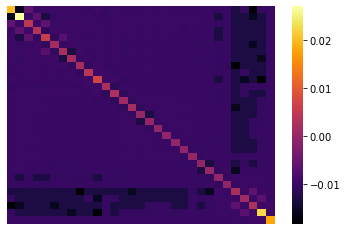

In [27]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(pd.DataFrame(covset_noise_test[0]), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

# covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
# covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
# covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
# covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))



In [28]:
input_img = tf.keras.Input(shape=(31, 31, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


# # input_cov = Input(shape=(31, 31, 1))

# # This is the size of our encoded representations
# encoding_dim = 31  

# # This is our input image
# input_img = tf.keras.Input(shape=(31*31,))
# # begin encoder
# x = layers.Dense(1000, activation='tanh')(input_img)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(500, activation='tanh')(x)
# x = layers.Dropout(0.2)(x)
# encoded = layers.Dense(encoding_dim, activation='tanh')(x)
# x = layers.Dropout(0.2)(encoded)
# #begin decoder
# x = layers.Dense(500, activation='tanh')(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(1000, activation='tanh')(x)
# x = layers.Dropout(0.2)(x)
# decoded = layers.Dense(31*31, activation='linear')(x)


# # This model maps an input to its reconstruction
# autoencoder = tf.keras.Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 31, 31, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 31, 31, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 8)           584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 8)           0   

In [29]:
# encoder = tf.keras.Model(input_img, encoded)
# # This is our encoded (32-dimensional) input
# encoded_input = tf.keras.Input(shape=(encoding_dim,))

# decoder_layer1 = autoencoder.layers[-5]
# decoder_layer2 = autoencoder.layers[-4]
# decoder_layer3 = autoencoder.layers[-3]
# decoder_layer4 = autoencoder.layers[-2]
# decoder_layer5 = autoencoder.layers[-1]

# # create the decoder model
# decoder = Model(encoded_input, 
#                 decoder_layer5(decoder_layer4(decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))))

In [30]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=10, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=100,
                batch_size=128,
#                 shuffle=True,
                validation_data=(covset_noise_test, covset_test))
#                 callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/100


ValueError: in user code:

    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1198 mean_squared_error
        return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:10250 squared_difference
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3528 _create_op_internal
        ret = Operation(
    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/cosmocicatais/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 28 and 31 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](mean_squared_error/remove_squeezable_dimensions/Squeeze, IteratorGetNext:1)' with input shapes: [?,28,28], [?,31,31].


(array([-1.e-06,  0.e+00,  1.e-06,  2.e-06,  3.e-06,  4.e-06,  5.e-06,
         6.e-06,  7.e-06]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

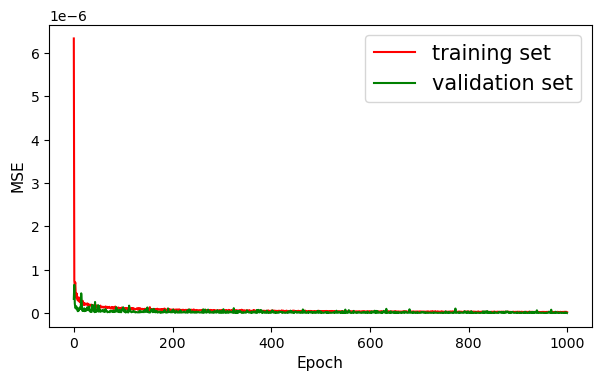

In [13]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.title('Autoencoder', fontsize=8)
# plt.savefig('loss_binned_JLA_.png')

In [14]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

4.27350466125631e-09 2.2498406693216566e-08


In [15]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
# np.min(encoded_imgs)

(2000, 100)


(2000, 961)


<AxesSubplot:>

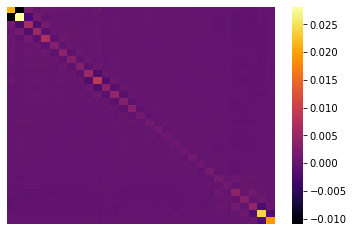

In [16]:
print(np.shape(decoded_imgs))

sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")
# this cov matrix work well within Bayesian inference
# np.savetxt("test.dat", decoded_imgs[0].reshape(31,31), delimiter= " ", header="#fake COV")


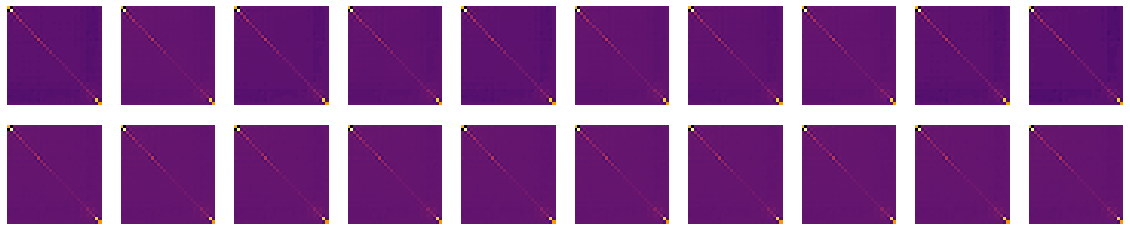

In [17]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
# plt.savefig('predicted_covs_binned_jla.png', dpi=200)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$



In [18]:
file2 = '/home/cosmocicatais/Documents/github/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
z = data.values[:,0]
dl = data.values[:,1:]

In [19]:
# fake_encoded = np.zeros((1, 31))
# avg_encoded = np.mean(encoded_imgs, axis=0)
# print(np.shape(avg_encoded))
# np.savetxt('avg_encoded.txt', avg_encoded, fmt='%.15e')
# ranz = z
# randl = dl+0.01

In [20]:
# for i, avg in enumerate(avg_encoded):
# #     alpha = avg/z[i]
#     alpha = avg/dl[i]
# #     fake_encoded[0, i] = alpha * ranz[i]
#     fake_encoded[0, i] = alpha * randl[i]

In [21]:
# decoded_fake = decoder.predict(fake_encoded)
# np.shape(decoded_fake), np.shape(fake_encoded)

In [22]:
# decoded_fake[0, :]

<AxesSubplot:>

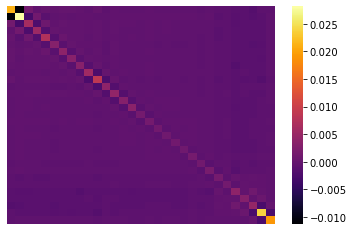

In [23]:
testmatrix = np.zeros((31,31))
err = np.random.rand() 
for row in range(nsize):
    for col in range(nsize):
        if row == col:
            testmatrix[row, col] = syscov[row, col]
        else:
            testmatrix[row, col] = syscov[row, col] + err*0.005*orderMag(syscov[row, col])

clean_img = autoencoder.predict(testmatrix.reshape(-1, 31*31,))
# clean_img = autoencoder.predict(covset_noise_test[0].reshape(-1, 31*31,))
# plt.savefig('fake_cov_jla.png', dpi=200)
# np.min(np.abs(decoded_fake[0, :]))]
sns.heatmap(pd.DataFrame(testmatrix), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

<AxesSubplot:>

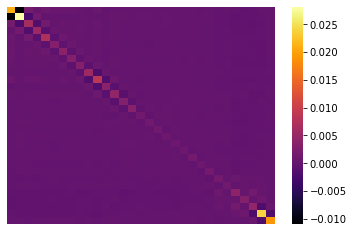

In [24]:
sns.heatmap(pd.DataFrame(clean_img[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)


In [25]:
# clean_img = autoencoder.predict(clean_img)
# # clean_img = autoencoder.predict(covset_noise_test[0].reshape(-1, 31*31,))
# # plt.savefig('fake_cov_jla.png', dpi=200)
# # np.min(np.abs(decoded_fake[0, :]))]
# sns.heatmap(clean_img, 
#         fmt='g', xticklabels=False, yticklabels=False, 
#         cmap = 'inferno', cbar=True,
#         robust=False)

In [34]:
np.savetxt("fake_binned_JLA_COVdecodedTEST1.dat", clean_img.reshape(31,31), delimiter= " ", header="#fake COV")


In [27]:
autoencoder.save('../models/autoencoderJLA.h5')
decoder.save('../models/decoderJLA.h5')
encoder.save('../models/encoderJLA.h5')

In [28]:
# np.min(np.abs(syscov - decoded_fake[0, :].reshape(31,31)))

In [29]:
# np.max(decoded_fake[0, :].reshape(31,31))

In [30]:
np.max(syscov)

0.02815552265

In [31]:
# np.min(decoded_fake[0, :].reshape(31,31))

In [32]:
# np.min(np.abs(syscov))